In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/OG/og.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/OG')'''

"import zipfile\n\nwith zipfile.ZipFile('/content/drive/MyDrive/OG/og.zip', 'r') as zip_ref:\n    zip_ref.extractall('/content/drive/MyDrive/OG')"

In [ ]:
print("Shreeram")

Shreeram


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = '/content/drive/MyDrive/OG/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
test_dir = '/content/drive/MyDrive/OG/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'
val_dir = '/content/drive/MyDrive/OG/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'

In [ ]:
BATCH_SIZE=32
IMG_HEIGHT=224
IMG_WIDTH=224

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)

Found 9246 files belonging to 2 classes.
Found 506 files belonging to 2 classes.
Found 829 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
class_names

['fractured', 'not fractured']

In [ ]:
def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

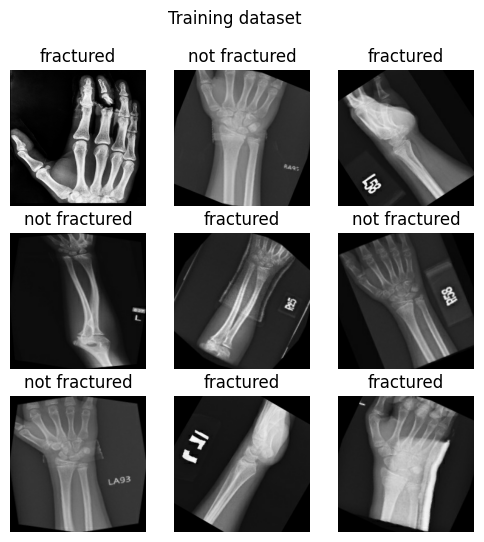

In [ ]:
show_images(train_ds, 'Training dataset')

In [ ]:
def count_classes(dataset, class_name):
    dataset_path = Path(dataset)
    return len(list(dataset_path.glob(f"{class_name}/*")))

def create_class_counts_df(dataset, class_names):
    counts = {'class': [], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

def plot_class_pie_chart(df, title):
    plt.pie(df['count'], labels=df['class'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(df)))
    plt.title(title)
    plt.axis('equal')
    plt.show()

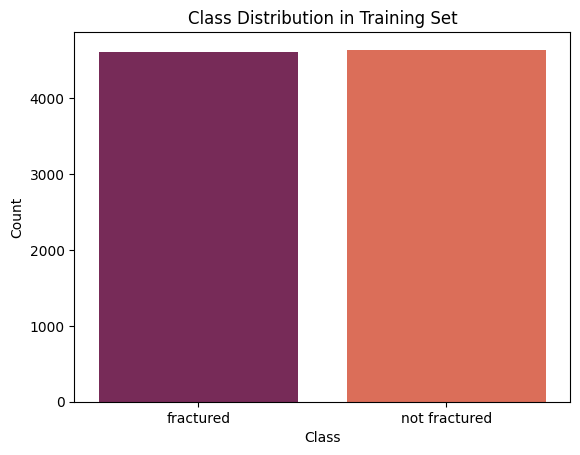

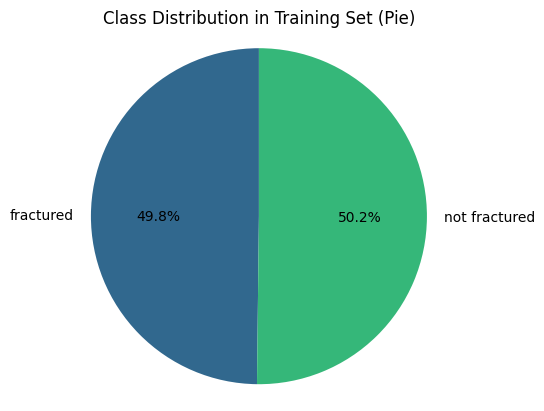

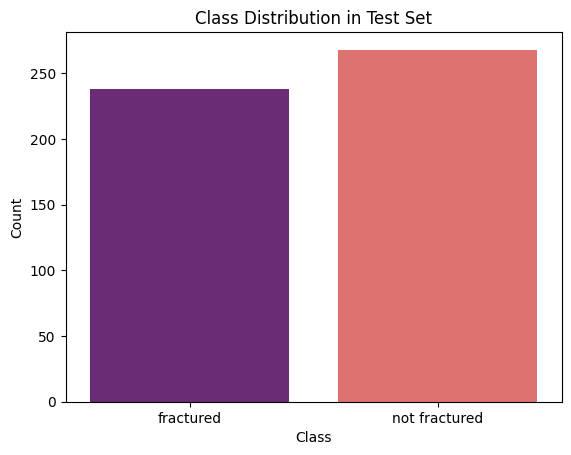

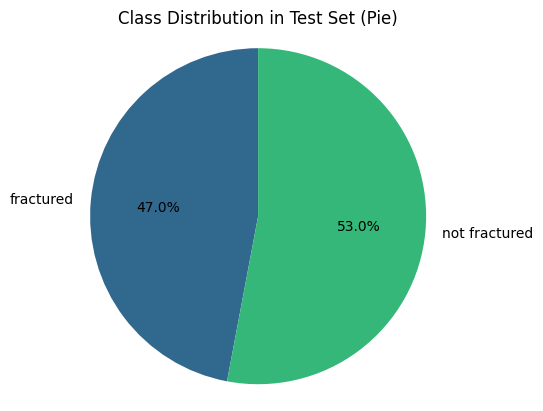

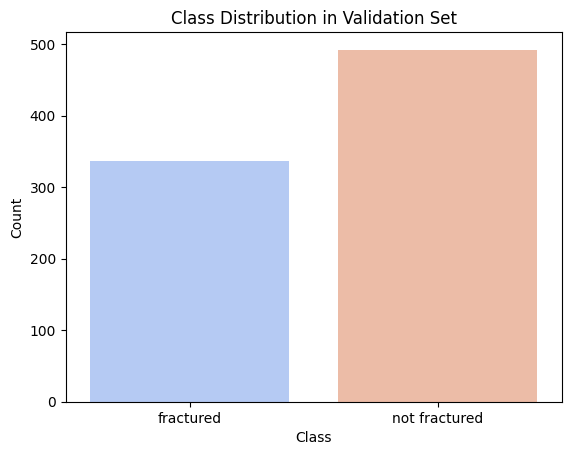

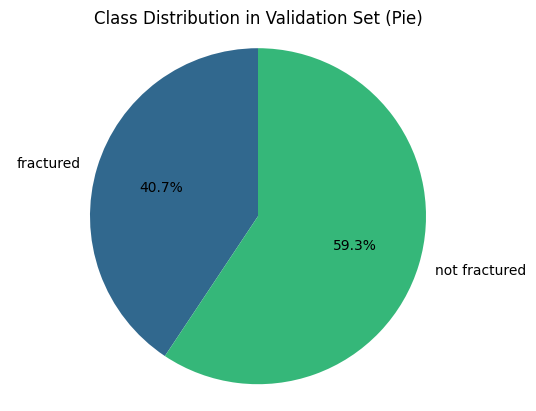

In [ ]:
class_names = ['fractured', 'not fractured']

train_df = create_class_counts_df(train_dir, class_names)
test_df = create_class_counts_df(test_dir, class_names)
val_df = create_class_counts_df(val_dir, class_names)

plot_class_distribution(train_df, 'Class Distribution in Training Set', palette='rocket')
plot_class_pie_chart(train_df, 'Class Distribution in Training Set (Pie)')

plot_class_distribution(test_df, 'Class Distribution in Test Set', palette='magma')
plot_class_pie_chart(test_df, 'Class Distribution in Test Set (Pie)')

plot_class_distribution(val_df, 'Class Distribution in Validation Set', palette='coolwarm')
plot_class_pie_chart(val_df, 'Class Distribution in Validation Set (Pie)')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=(0.8,1.2),
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_dir,target_size=(IMG_HEIGHT, IMG_WIDTH),batch_size=32,class_mode='binary')
test_set = test_datagen.flow_from_directory(test_dir,target_size=(IMG_HEIGHT, IMG_WIDTH),batch_size=32,class_mode='binary')
val_set = val_datagen.flow_from_directory(val_dir,target_size=(IMG_HEIGHT, IMG_WIDTH),batch_size=32,class_mode='binary')

Found 9246 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 829 images belonging to 2 classes.


VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

def create_vgg16_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
vgg16_model = create_vgg16_model(input_shape)
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
learning_rate = 0.0001
sujay=vgg16_model.fit(training_set, validation_data=val_set, epochs=40, batch_size=BATCH_SIZE, callbacks=[lr_decay])
block_layers = {
    3: range(7, 11),
    4: range(11, 15),
    5: range(15, 18)
}
unfreeze_schedule = {
    3: (40, 60),
    4: (60, 80),
    5: (80, 100)
}
for block_num, epoch_range in unfreeze_schedule.items():
    start_epoch, end_epoch = epoch_range
    print(f"Unfreezing layers for Block {block_num} between epochs {start_epoch} and {end_epoch}:")
    for layer_index in block_layers[block_num]:
        vgg16_model.layers[layer_index].trainable = True
        print(f"  - {vgg16_model.layers[layer_index].name}")
    learning_rate *= 0.1
    vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    sujay = vgg16_model.fit(training_set, validation_data=val_set, epochs=end_epoch, initial_epoch=start_epoch, batch_size=BATCH_SIZE, callbacks=[lr_decay])

Epoch 1/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 1674s 6s/step - accuracy: 0.6011 - loss: 8.6689 - val_accuracy: 0.8227 - val_loss: 2.9444 - learning_rate: 1.0000e-04
Epoch 2/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 211s 608ms/step - accuracy: 0.7420 - loss: 2.6295 - val_accuracy: 0.8420 - val_loss: 1.6277 - learning_rate: 1.0000e-04
Epoch 3/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 203s 616ms/step - accuracy: 0.7944 - loss: 1.5522 - val_accuracy: 0.8649 - val_loss: 1.0588 - learning_rate: 1.0000e-04
Epoch 4/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 181s 613ms/step - accuracy: 0.8239 - loss: 1.0788 - val_accuracy: 0.8420 - val_loss: 0.8424 - learning_rate: 1.0000e-04
Epoch 5/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 180s 608ms/step - accuracy: 0.8298 - loss: 0.8536 - val_accuracy: 0.8854 - val_loss: 0.6778 - learning_rate: 1.0000e-04
Epoch 6/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 205s 619ms/step - accuracy: 0.8510 - loss: 0.7188 - val_accuracy: 0.8963 - val_loss: 0.5875 - learning_rate: 1.0000e-04
Epoch 7/40
289/289 ━━━━━━━━━━━━━━━━━━━━ 18

In [ ]:
test_loss, test_acc = vgg16_model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step - accuracy: 0.9696 - loss: 0.1555
Test Accuracy: 0.97
Test Loss: 0.16


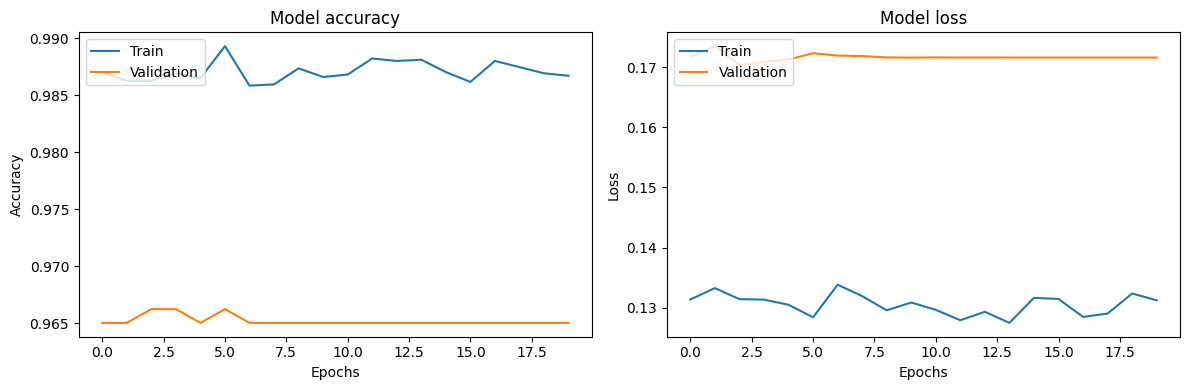

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(sujay.history['accuracy'])
plt.plot(sujay.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(sujay.history['loss'])
plt.plot(sujay.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


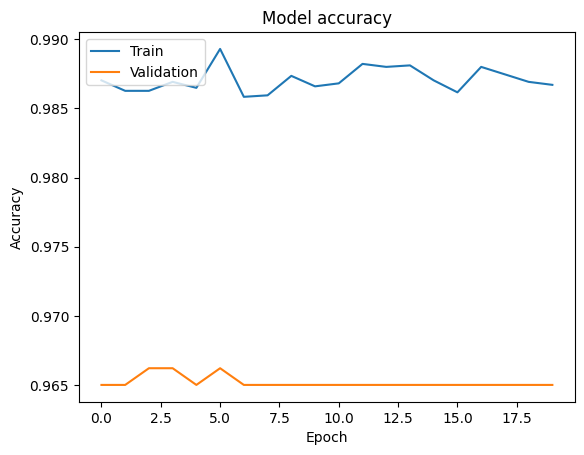

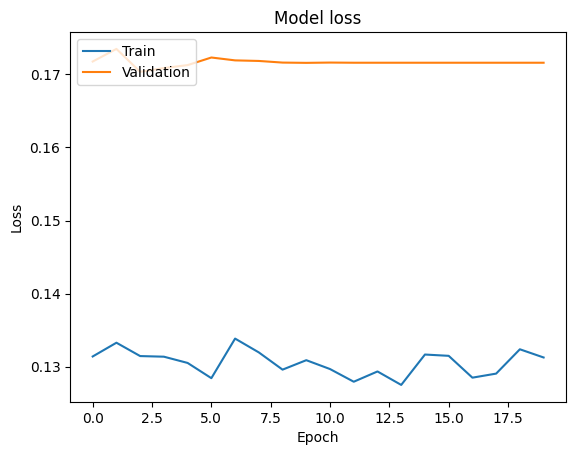

In [ ]:
plt.plot(sujay.history['accuracy'])
plt.plot(sujay.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(sujay.history['loss'])
plt.plot(sujay.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
vgg16_model.save('Researchvgg16.keras')

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

def create_incept_model(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
incept_model = create_incept_model(input_shape)
incept_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-8)
learning_rate = 0.0001
sujay=incept_model.fit(training_set, validation_data=val_set, epochs=5, batch_size=BATCH_SIZE, callbacks=[lr_decay])
layer_patterns = [
    "mixed7",
    "mixed8",
    "mixed9",
    "mixed10",
]
unfreeze_schedule = {
    "initial_blocks": (2, 3),
    "final_blocks": (3, 5)
}
for block_num, epoch_range in unfreeze_schedule.items():
    start_epoch, end_epoch = epoch_range
    print(f"Unfreezing layers for Block {block_num} between epochs {start_epoch} and {end_epoch}:")
    if block_name == "initial_blocks":
        pass
    elif block_name == "final_blocks":
        for layer in incept_model.layers:
            if any(pattern in layer.name for pattern in layer_patterns):
                layer.trainable = True
                print(f"Unfreezing layer: {layer.name}")
    learning_rate *= 0.1
    vgg19_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    sujay = vgg19_model.fit(training_set, validation_data=val_set, epochs=end_epoch, initial_epoch=start_epoch, batch_size=BATCH_SIZE, callbacks=[lr_decay])

Epoch 1/5
 10/289 ━━━━━━━━━━━━━━━━━━━━ 23:47 5s/step - accuracy: 0.4843 - loss: 15.2632

KeyboardInterrupt: 